This is a small notebook regarding MIDI file manipulation using Music21, in this file we will:
* Open MIDI files;
* Plot MIDI music data;
* Manipulate notes and chords;
* Use Word2Vec to analyze chords.

[You can find a high-level description of it on this Medium article.](https://medium.com/@wfaria_1/midi-music-data-extraction-using-music21-and-word2vec-on-kaggle-cb383261cd4e)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Listing current data on our folder.
import os
print(os.listdir("."))


['.ipynb_checkpoints', 'download_midi.log', 'midi-music-data-extraction-using-music21.ipynb', 'MIDIs']


## Opening MIDI files

Lets start creating a small method  to download MIDI files:

In [14]:
!mkdir $midi_path

지정된 파일을 찾을 수 없습니다.


In [5]:
# Defining some constants and creating a new folder for MIDIs.
midi_path = "Music_MIDIs"
sonic_folder = "pop"

!rd -s $midi_path
!mkdir $midi_path

# Some helper methods.    
def concat_path(path, child):
    return path + "/" + child

def download_midi(midi_url, path):
    !wget $midi_url --directory-prefix $path > download_midi.log

# Downloading an example file.
sonic_path = concat_path(midi_path, sonic_folder)
download_midi(
        "https://files.khinsider.com/midifiles/genesis/sonic-the-hedgehog/green-hill-zone.mid",
    sonic_path)
    
print(os.listdir(sonic_path))


지정된 파일을 찾을 수 없습니다.
디렉터리가 비어 있지 않습니다.
하위 디렉터리 또는 파일 Music_MIDIs이(가) 이미 있습니다.


['green-hill-zone.mid']


--2020-07-31 16:38:26--  https://files.khinsider.com/midifiles/genesis/sonic-the-hedgehog/green-hill-zone.mid
Resolving files.khinsider.com (files.khinsider.com)... 45.56.66.21
Connecting to files.khinsider.com (files.khinsider.com)|45.56.66.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13034 (13K) [audio/midi]
Saving to: 'Music_MIDIs/pop/green-hill-zone.mid'

     0K .......... ..                                         100% 22.1M=0.001s

2020-07-31 16:38:27 (22.1 MB/s) - 'Music_MIDIs/pop/green-hill-zone.mid' saved [13034/13034]



In [6]:
midi_path = "Music_MIDIs"
sonic_folder = "pop"

!rd -s $midi_path
!mkdir $midi_path

def concat_path(path, child):
    return path + "/" + child

def download_midi(midi_url, path):
    !wget $midi_url --directory-prefix $path > download_midi.log

지정된 파일을 찾을 수 없습니다.
디렉터리가 비어 있지 않습니다.
하위 디렉터리 또는 파일 Music_MIDIs이(가) 이미 있습니다.


Now we have a midi file there, lets try to open it using music21 library, which seems to be a robust platform to explore music files and music theory.

Note that I included it as an external package on this Kaggle notebook. I used its [github link](https://github.com/cuthbertLab/music21) to do that. You can find its documentation [here](http://web.mit.edu/music21/doc/usersGuide/index.html).

In [18]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch

def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi(concat_path(sonic_path, "green-hill-zone.mid"), True)
base_midi


<music21.stream.Score 0x150c400bd48>

## Debugging MIDI data

We can start listing the instruments used on that music:

In [19]:
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        print (p.partName)

list_instruments(base_midi)


List of instruments found on MIDI file:
None
None
None
None
None
None
None
Electric Guitar


Well we got a lot of unnamed instruments and one guitar... Differently from Scores created on Sheet editors like [MuseScore](https://musescore.org), which are crafted to be read by a musician. MIDIs are usually genereted on Digital Audio Workstations (DAW) as [LMMS](https://lmms.io) which have as objective the music audio generation. This way the presentation can be pretty unfriendly.

Check the following plot with notes as if we are using a DAW displaying the composition on the [piano roll](https://lmms.io/wiki/index.php?title=Piano_Roll_Editor):

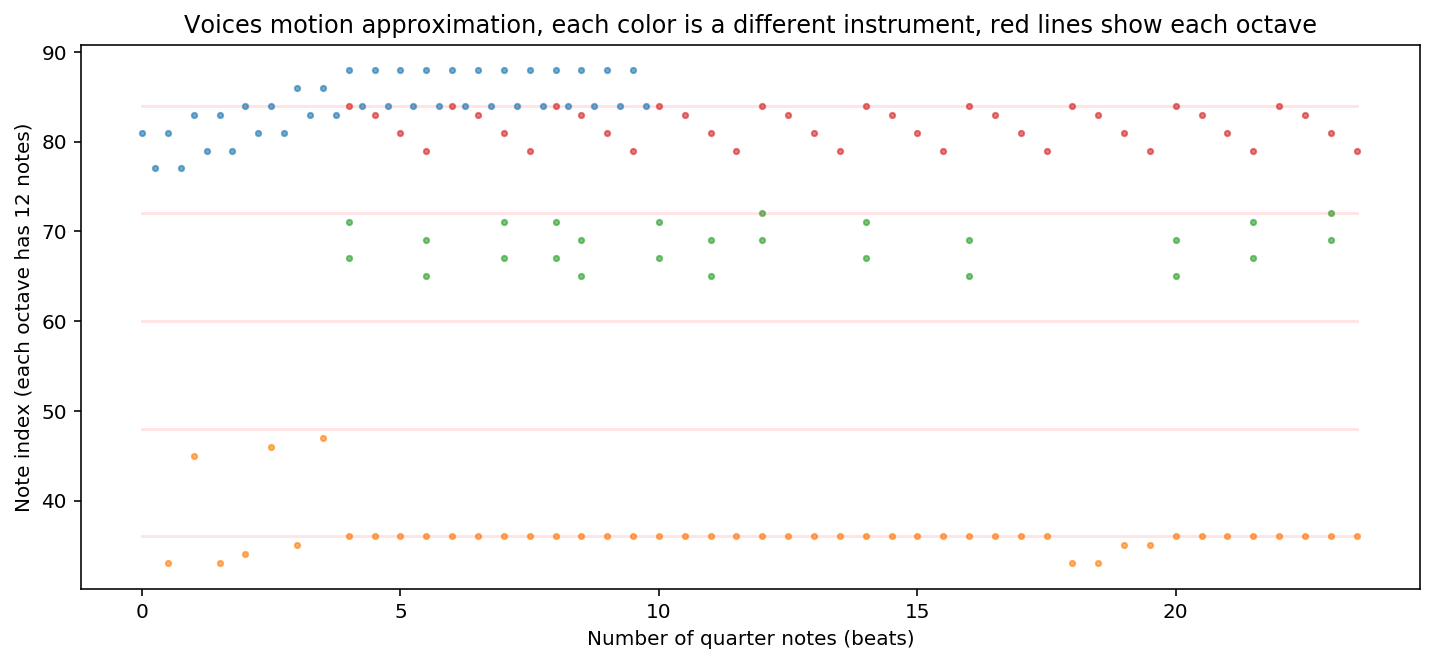

In [20]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))

If you know the [original song](https://www.youtube.com/watch?v=y-78CMKME4o), you can identify some known parts as the initial arpeggio at the beginning and the melody starting after it.  If we plot more measures, we can see the music structure. However, it is hard to extract pitch information from it.

We can take a look on the pitch histogram to see which notes are more used. If you know a bit of music theory, you'll notice that the seven more used notes are part of [C-major/A-minor Key](https://en.wikipedia.org/wiki/C_major), so this would be a good way to guess the music's key.

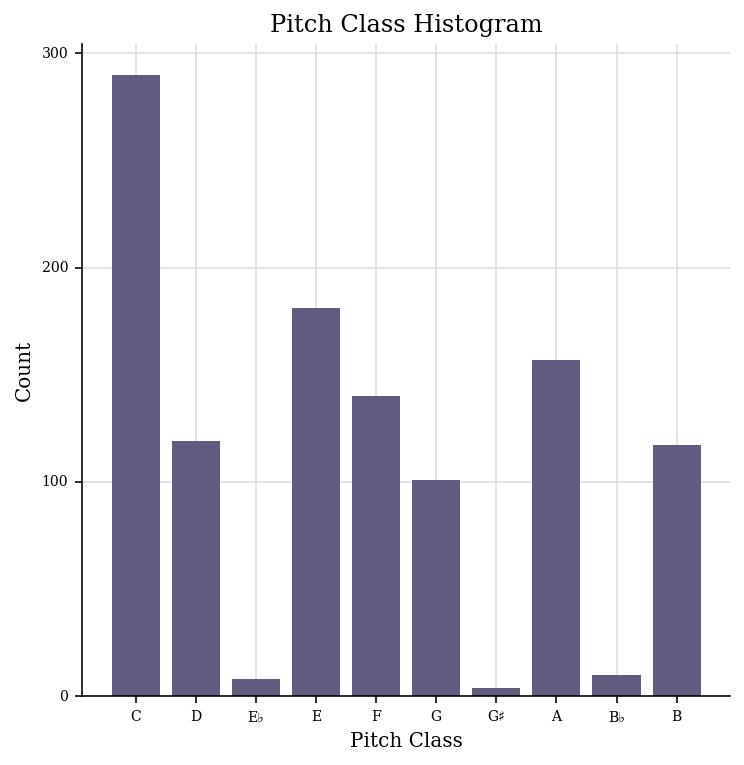

In [21]:
base_midi.plot('histogram', 'pitchClass', 'count')

The scatter plot shows that the use of notes look consistent through time, so there are no key changes in this piece.

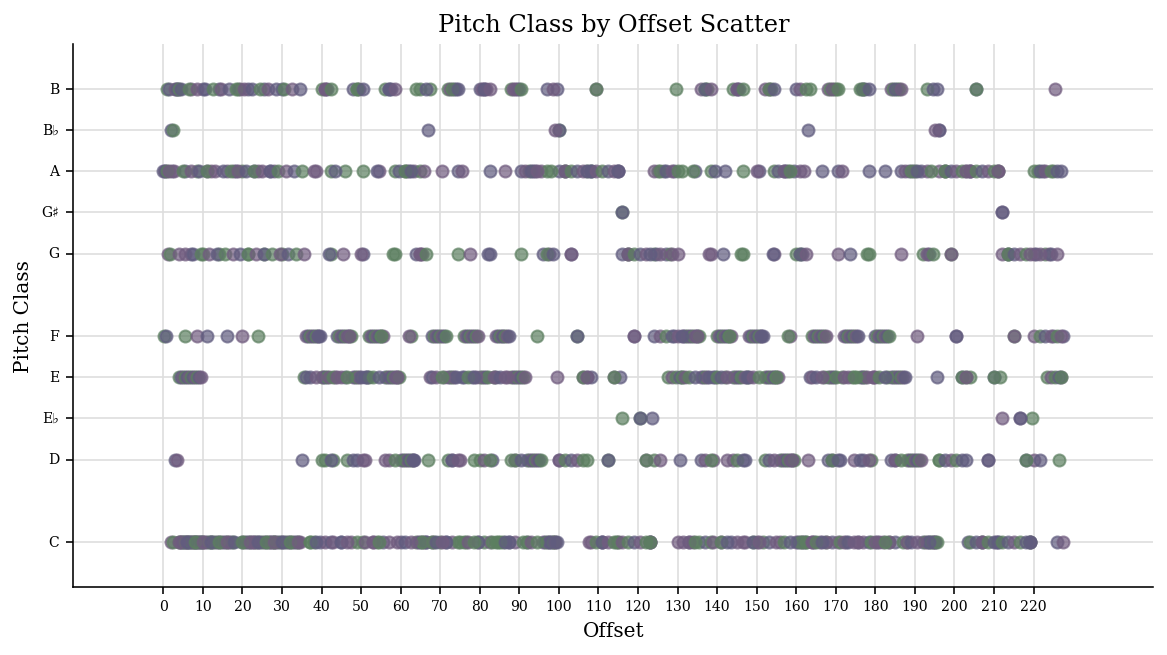

In [22]:
base_midi.plot('scatter', 'offset', 'pitchClass')

After seeing those graphics, we can be more confident in analyzing that music, lets take a look on some extra composition parameters:

In [23]:
timeSignature = base_midi.getTimeSignatures()[0]
music_analysis = base_midi.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)

Music time signature: 4/4
Expected music key: a minor
Music key confidence: 0.8770275812674332
Other music key alternatives:
C major
F major
G major
d minor


## Harmonic Reduction

It would be good to have the harmonic sequence of the music to analyze how it was built and to compare it with other musics. [Citing the wikipedia explanation about this](https://en.wikipedia.org/wiki/Reduction_(music%29):

> In music, a reduction is an arrangement or transcription of an existing score or composition in which complexity is lessened to make analysis, performance, or practice easier or clearer; the number of parts may be reduced or rhythm may be simplified, such as through the use of block chords. 

Lets start merging all voices on the same one and visualizing its contents:

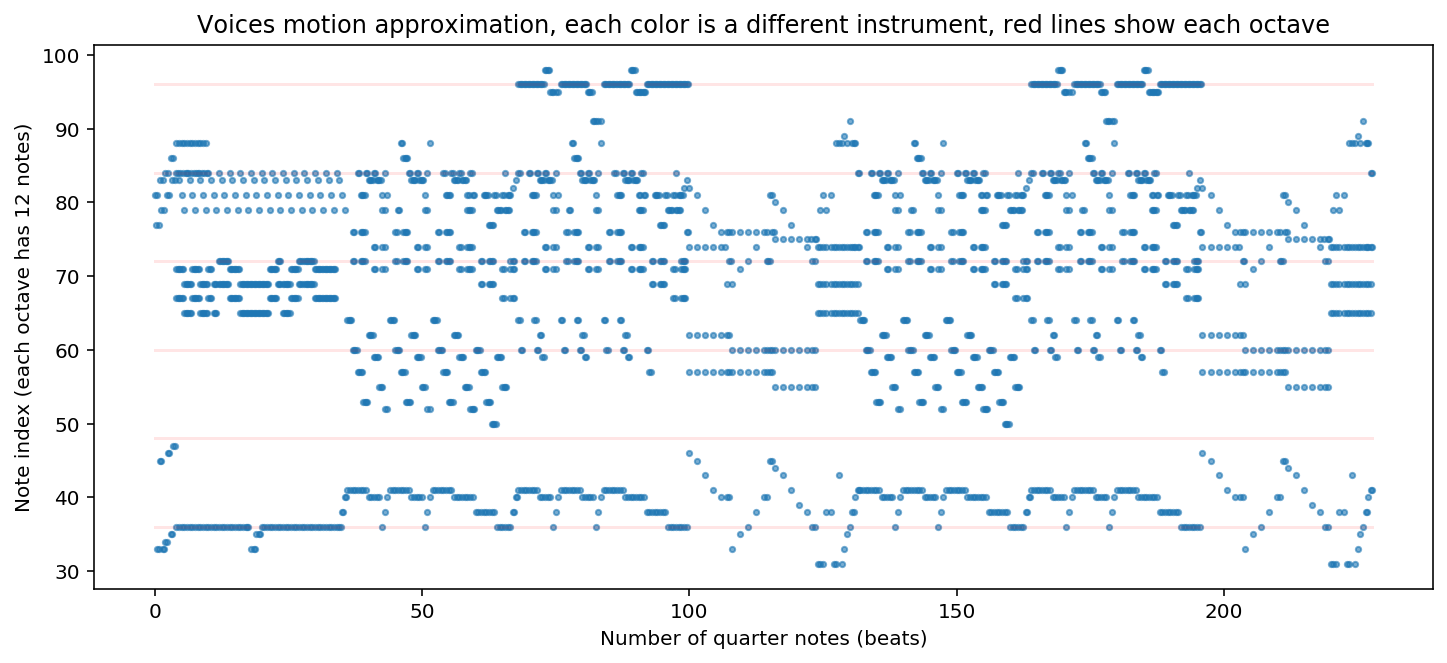

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Instrument ''>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=175.0>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord A5>
    {0.25} <music21.chord.Chord F5>
    {0.5} <music21.chord.Chord A1 A5>
    {0.75} <music21.chord.Chord A1 F5>
    {1.0} <music21.chord.Chord A2 B5>
    {1.25} <music21.chord.Chord A2 G5>
    {1.5} <music21.chord.Chord A1 B5>
    {1.75} <music21.chord.Chord A1 G5>
    {2.0} <music21.chord.Chord B-1 C6>
    {2.25} <music21.chord.Chord B-1 A5>
    {2.5} <music21.chord.Chord B-2 C6>
    {2.75} <music21.chord.Chord B-2 A5>
    {3.0} <music21.chord.Chord B1 D6>
    {3.25} <music21.chord.Chord B1 B5>
    {3.5} <music21.chord.Chord B2 D6>
    {3.75} <music21.chord.Chord B2 B5>


In [24]:
from music21 import stream

temp_midi_chords = open_midi(
    concat_path(sonic_path, "green-hill-zone.mid"),
    True).chordify()
temp_midi = stream.Score()
temp_midi.insert(0, temp_midi_chords)

# Printing merged tracks.
print_parts_countour(temp_midi)

# Dumping first measure notes
temp_midi_chords.measures(0, 1).show("text")

The previous cell just merged all instruments, so each measure became flooded with a lot of chords. Each measure contains Four beats as showed previously, so lets try to display only the most used chord for each measure. We will try to find the chord counting the 4 most used notes per measure and trying to create a Chord with it. For example, if we find (E4, G4, C5, G5) then we would have a C-major chord on the [First inversion](https://en.wikipedia.org/wiki/Inversion_(music%29#Inversions):

In [25]:
from music21 import roman

def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        # All notes have the same length of its chord parent.
        note_length = chord.quarterLength
        for note in chord.pitches:          
            # If note is "C5", note.name is "C". We use "C5"
            # style to be able to detect more precise inversions.
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
                
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length
        
    return bass_note
                
def simplify_roman_name(roman_numeral):
    # Chords can get nasty names as "bII#86#6#5",
    # in this method we try to simplify names, even if it ends in
    # a different chord to reduce the chord vocabulary and display
    # chord function clearer.
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    
    # Checking valid inversions.
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
        
    if (inversion_name is not None):
        ret = ret + str(inversion_name)
        
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret
                
def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)    
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4   
    for m in temp_midi_chords.measures(0, None): # None = get all measures.
        if (type(m) != stream.Measure):
            continue
        
        # Here we count all notes length in each measure,
        # get the most frequent ones and try to create a chord with them.
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") # Empty measure
            continue
        
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        
        # Convert the chord to the functional roman representation
        # to make its information independent of the music key.
        roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        ret.append(simplify_roman_name(roman_numeral))
        
    return ret

harmonic_reduction(base_midi)[0:10]

['ii42', 'III43', '-VI64', 'i42', '-VI', 'i65', 'i65', 'i42', 'III7', 'vi7']

The previous harmonic reduction looks pretty confusing, maybe the melodic lines include several [nonchord notes](https://en.wikipedia.org/wiki/Nonchord_tone) which changes the Chord Quality. If we get a music like Bach's [Prelude in C-major](https://www.youtube.com/watch?v=RXeu8-j9k9Q) which uses a lot of chord arpeggios, we can see that our function works pretty well. At least on the beginning it gets almost all correct chords and other with minor errors.

In [7]:
from music21 import corpus

bachChorale = corpus.parse('bach/bwv846')
harmonic_reduction(bachChorale)[0:11]

NameError: name 'harmonic_reduction' is not defined

In [8]:
soup.find_all('a')

NameError: name 'soup' is not defined

## MIDI Processing

So far we learned how to:
* Open MIDI files;
* Manipulate tracks and notes;
* Plot music structure;
* Analyze MIDI basic features as time signatures;
* Analyze music elements as key signature and harmonic progressions.

Now that we know the basics to handle MIDI data, lets download a bunch of MIDI files and play with them.



In [4]:
import requests
from bs4 import BeautifulSoup

def get_file_name(link):
    filename = link.split('/')[::-1][0]
    return filename

def download_file(link, filename):
    mid_file_request = requests.get(link, stream=True)
    if (mid_file_request.status_code != 200):
        raise Exception("Failed to download {0}".format(url))
        
    with open(filename, 'wb+') as saveMidFile:
        saveMidFile.write(mid_file_request.content)

def download_midi_files(url, output_path):
    site_request = requests.get(url)
    if (site_request.status_code != 200):
        raise Exception("Failed to access {0}".format(url))
    
    soup = BeautifulSoup(site_request.content, 'html.parser')
    link_urls = soup.find_all('a')

    for link in link_urls:
        href = link['href']
        if (href.endswith(".mid")):
            file_name = get_file_name(href)
            download_path = concat_path(output_path, file_name)
            midi_request = download_file(href, download_path)

def start_midis_download(folder, url):
    #!mkdir $folder # It is fine if this command fails when the directory already exists.
    download_midi_files(url, folder)

target_musics = dict()
target_musics["pop"] = "https://www.midiworld.com/search/?q=pop"


for key, value in target_musics.items():
    file_path = concat_path(sonic_path, key)
    start_midis_download(file_path, value)

SyntaxError: invalid syntax (<ipython-input-4-d0ccc1fa8b26>, line 38)

In [10]:
import pandas as pd
from bs4 import BeautifulSoup as bs
import os
import sys
import requests
import re #정규식 사용을 위함 

In [11]:
url="https://www.midiworld.com/search/?q=pop"
res = requests.get(url) #urllib.request.urlopen이랑 같은거 : 사이트마다 안될시 이용해볼것!!
soup = bs(res.text, "html.parser")

In [21]:
link_urls = soup.find_all('a')

In [22]:
href = link_urls\
['href']

TypeError: list indices must be integers or slices, not str

We downloaded more than 450 Sonic MIDIs (Almost 14MBs of files). The source site contains different versions of the same music created by fans, some of them are extended with new parts while others are more similar to the base composition, but they should share the same structure and key features. Lets finally convert them to a Pandas Dataframe including the harmonic reduction for each file.

In [1]:
# from multiprocessing.dummy import Pool as ThreadPool # Use this when IO is the problem
from multiprocessing import Pool # Use this when CPU-intensive functions are the problem.

# Go get a coffee, this cell takes hours to run...
def process_single_file(midi_param):
    try:
        game_name = midi_param[0]
        midi_path = midi_param[1]
        midi_name = get_file_name(midi_path)
        midi = open_midi(midi_path, True)
        return (
            midi.analyze('key'),
            game_name,
            harmonic_reduction(midi),
            midi_name)
    except Exception as e:
        print("Error on {0}".format(midi_name))
        print(e)
        return None

def create_midi_dataframe(target_games):
    key_signature_column = []
    game_name_column = []
    harmonic_reduction_column = []
    midi_name_column = []
    pool = Pool(8)
    midi_params = []
    for key, value in target_games.items():
        folder_path = concat_path(sonic_path, key)
        for midi_name in os.listdir(folder_path):
            midi_params.append((key, concat_path(folder_path, midi_name)))

    results = pool.map(process_single_file, midi_params)
    for result in results:
        if (result is None):
            continue
            
        key_signature_column.append(result[0])
        game_name_column.append(result[1])
        harmonic_reduction_column.append(result[2])
        midi_name_column.append(result[3])
    
    d = {'midi_name': midi_name_column,
         'game_name': game_name_column,
         'key_signature' : key_signature_column,
         'harmonic_reduction': harmonic_reduction_column}
    return pd.DataFrame(data=d)

sonic_df = create_midi_dataframe(target_games)

NameError: name 'target_games' is not defined

There were some minor errors on the last cell but we were able to process almost all files. We can check the Key Signatures from those musics and notice that simpler Key Signatures as C-major, A-minor, F-major and D-minor were most common on the first Sonic games, then on Sonic 3 this changed (maybe because of [Michael Jackson](https://www.billboard.com/articles/news/6858197/michael-jackson-sonic-hedgehog-3-music-theory)? :P). Finally on Sonic and Knuckles it starts to use A-minor more frequently again.

In [ ]:
def key_hist(df, game_name, ax):
    title = "All Games Key Signatures"
    filtered_df = df
    if (game_name is not None):
        title = game_name + " Key Signatures"
        filtered_df = df[df["game_name"] == game_name]
        
    filtered_df["key_signature"].value_counts().plot(ax = ax, kind='bar', title = title)

fig, axes = plt.subplots(nrows=int(len(target_games)/3) + 1, ncols = 3, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
key_hist(sonic_df, None, axes[0, 0])
i = 1
for key, value in target_games.items():
    key_hist(sonic_df, key, axes[int(i/3), i%3])
    i = i + 1

sonic_df.head()

Since the harmonic sequences are just a list of strings, we could handle it as a common sentence from a text document. Lets try to use [word2vec](https://towardsdatascience.com/learn-word2vec-by-implementing-it-in-tensorflow-45641adaf2ac) (more [here](https://medium.freecodecamp.org/how-to-get-started-with-word2vec-and-then-how-to-make-it-work-d0a2fca9dad3)) to find some relationships between chords on Sonic games compositions.

In [ ]:
# import modules & set up logging
import gensim, logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
 
model = gensim.models.Word2Vec(sonic_df["harmonic_reduction"], min_count=2, window=4)

For example, if we want to study how [Chord Substitutions](https://en.wikipedia.org/wiki/Chord_substitution) are applied on Sonic musics, we could find the most similar chords based on the model which we trained previously:

In [ ]:
def get_related_chords(token, topn=3):
    print("Similar chords with " + token)
    for word, similarity in model.wv.most_similar(positive=[token], topn=topn):
        print (word, round(similarity, 3))

def get_chord_similarity(chordA, chordB):
    print("Similarity between {0} and {1}: {2}".format(
        chordA, chordB, model.wv.similarity(chordA, chordB)))
    
print("List of chords found:")
print(model.wv.vocab.keys())
print("Number of chords considered by model: {0}".format(len(model.wv.vocab)))

get_related_chords('I')
get_related_chords('iv')
get_related_chords('V')

# The first one should be smaller since "i" and "ii" chord doesn't share notes,
# different from "IV" and "vi" which share 2 notes.
get_chord_similarity("I", "ii") 
get_chord_similarity("IV", "vi")

# This one should be bigger because they are "enharmonic".
get_chord_similarity("-i", "vii")


One more example. We can try to calculate the similarity between musics using the harmonic reducton based on this [code](https://github.com/v1shwa/document-similarity/blob/master/DocSim.py). For example, if we would like to find more musics that looks like the Sonic 1's Green Hill theme, we could do this:

In [6]:
import pprint
def vectorize_harmony(model, harmonic_reduction):
    # Gets the model vector values for each chord from the reduction.
    word_vecs = []
    for word in harmonic_reduction:
        try:
            vec = model[word]
            word_vecs.append(vec)
        except KeyError:
            # Ignore, if the word doesn't exist in the vocabulary
            pass
    
    # Assuming that document vector is the mean of all the word vectors.
    return np.mean(word_vecs, axis=0)

def cosine_similarity(vecA, vecB):
    # Find the similarity between two vectors based on the dot product.
    csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
    if np.isnan(np.sum(csim)):
        return 0
    
    return csim

def calculate_similarity_aux(df, model, source_name, target_names=[], threshold=0):
    source_harmo = df[df["midi_name"] == source_name]["harmonic_reduction"].values[0]
    source_vec = vectorize_harmony(model, source_harmo)    
    results = []
    for name in target_names:
        target_harmo = df[df["midi_name"] == name]["harmonic_reduction"].values[0]
        if (len(target_harmo) == 0):
            continue
            
        target_vec = vectorize_harmony(model, target_harmo)       
        sim_score = cosine_similarity(source_vec, target_vec)
        if sim_score > threshold:
            results.append({
                'score' : sim_score,
                'name' : name
            })
                
    # Sort results by score in desc order
    results.sort(key=lambda k : k['score'] , reverse=True)
    return results

def calculate_similarity(df, model, source_name, target_prefix, threshold=0):
    source_midi_names = df[df["midi_name"] == source_name]["midi_name"].values
    if (len(source_midi_names) == 0):
        print("Invalid source name")
        return
    
    source_midi_name = source_midi_names[0]
    
    target_midi_names = df[df["midi_name"].str.startswith(target_prefix)]["midi_name"].values  
    if (len(target_midi_names) == 0):
        print("Invalid target prefix")
        return
    
    return calculate_similarity_aux(df, model, source_midi_name, target_midi_names, threshold)

pp = pprint.PrettyPrinter(width=41, compact=True)
pp.pprint(calculate_similarity(sonic_df, model, "green-hill-zone.mid", "green")) # sonic1 x sonic1 music
pp.pprint(calculate_similarity(sonic_df, model, "green-hill-zone.mid", "emerald")) # sonic1 x sonic2 music
pp.pprint(calculate_similarity(sonic_df, model, "green-hill-zone.mid", "hydro")) # sonic1 x sonic3 music
pp.pprint(calculate_similarity(sonic_df, model, "green-hill-zone.mid", "sando")) # sonic1 x s&k music

NameError: name 'sonic_df' is not defined

In [7]:
from mido import MidiFile

It is good to see that the Green hill music is pretty similar with itself and with other versions based on the same piece. When we compare it with other musics, the similarity value begins to decrease. 

## Final considerations

This was just a demonstrative code with some ideas to work with MIDI data. I believe that there is space to improve the chord detection and the harmonic reduction. Also I am not sure if the amount of data used here are enough to make word2vec train a model fine.  If you find some bug or have some feedback please let me know!